# Kaggle Competition

### Instance Segmentation

Dataset: PanNuke Dataset

Authors: Mathieu Tardy, Tom Terrier

In [7]:
# Import packages

import matplotlib.pyplot as plt
import numpy as np
import os, cv2, glob
import torch, torchvision

from torch.utils.data.dataset import Dataset
from skimage import io
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

from PIL import Image
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from tqdm import tqdm
import matplotlib.pyplot as plt
# from skimage.morphology import binary_opening, disk, label

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/CENTRALE/Deep_Learning/kaggle_competition/'
im_path = path+"train_images/train_images/*.png"
mask_path = path+"train_masks/train_masks/*.png"

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");

Mounted at /content/drive


In [15]:
param = {
    'batch_size': 4,
    'num_workers': 6,
    'epochs': 10,
    'lr': 0.01,
    }

# Load Images

In [16]:
def fetch_images(im_path, mask_path):
    image_list = list(glob.glob(os.path.join(im_path)))
    mask_list = list(glob.glob(os.path.join(mask_path)))
    image_list = np.sort(image_list)
    mask_list = np.sort(mask_list)

    assert (image_list.shape[0] > 0)
    assert (mask_list.shape[0] > 0 )

    threshold = int(0.8*len(image_list))
    train_images = image_list[:threshold]
    train_masks = mask_list[:threshold]
    validation_images = image_list[threshold:]
    validation_masks = mask_list[threshold:]

    return train_images, train_masks, validation_images, validation_masks

In [17]:
class MyDataset(Dataset):
    def __init__(self, image_list, mask_list, transform=None):
        ##Load array of images and masks
        self.images = image_list
        self.masks = mask_list
        self.transform = transform

    def __getitem__(self, index):
        ## Get the image-label set 
        if self.transform:
          image = self.transform(Image.open(self.images[index]))
        else:
          image = np.array(Image.open(self.images[index]))
          image = np.transpose(image, (2,0,1))

        mask = np.array(Image.open(self.masks[index]))
        mask = (mask - 1)/254.0

        return image, mask

    def __len__(self):
        ## return the total number of data samples
        return len(self.images)

In [18]:
# Load and transform data

train_images, train_masks, validation_images, validation_masks = fetch_images(im_path, mask_path)

transform = transforms.Compose([
     transforms.ToTensor(),
])
  

train_dataset = MyDataset(train_images, train_masks, transform= None)
val_dataset = MyDataset(validation_images, validation_masks, transform = None)
n_train = len(train_dataset)
n_val = len(val_dataset)

del train_images
del train_masks
del validation_images
del validation_masks

train_dataloader = DataLoader( train_dataset, batch_size = param['batch_size'],
                              pin_memory=torch.cuda.is_available(),
                              num_workers=param['num_workers'],
                              shuffle=True, drop_last=True)
val_dataloader = DataLoader( val_dataset, batch_size = param['batch_size'],
                            pin_memory=torch.cuda.is_available(),
                            num_workers=param['num_workers'],
                            shuffle=False, drop_last=True)

del train_dataset
del val_dataset

Image shape: torch.Size([32, 3, 256, 256])

Masks shape : torch.Size([32, 256, 256])


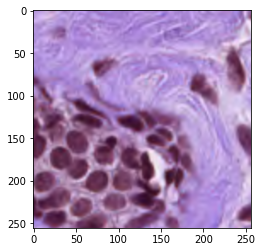

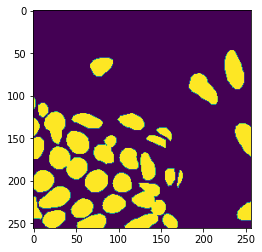

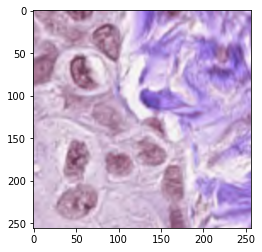

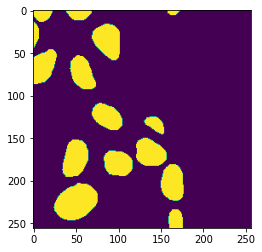

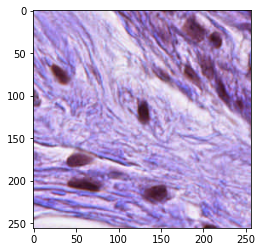

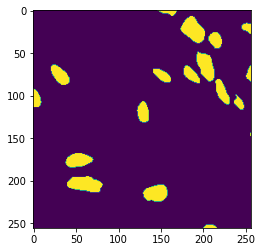

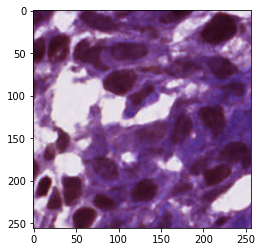

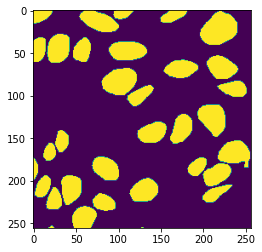

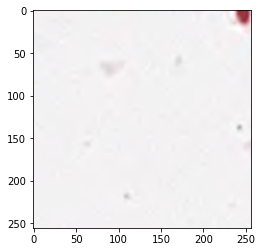

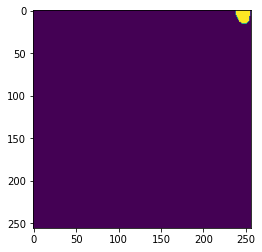

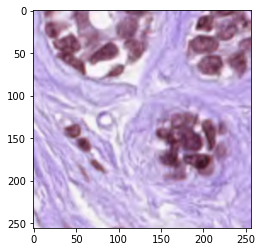

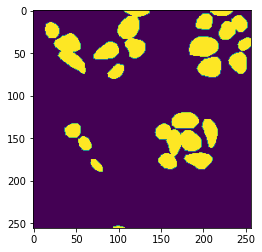

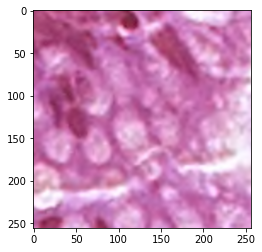

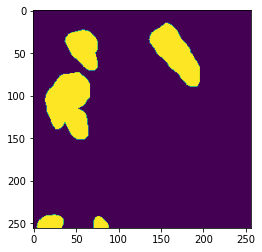

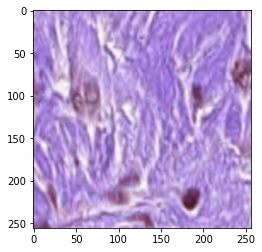

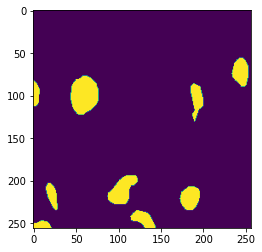

In [19]:
# Show images
for idx,(images, masks) in enumerate(train_dataloader):
  if idx == 2:
    break
  for i in range(param["batch_size"]):
    plt.imshow(np.transpose(images[i].numpy(), (1,2,0)))
    plt.show()
    plt.imshow(masks[i].numpy())
    plt.show()

# Model

In [20]:
# Build Unet: https://github.com/milesial/Pytorch-UNet/tree/master/unet

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.n_filters = n_filters

        self.inc = DoubleConv(n_channels, n_filters)#n_filters: initally 64
        self.down1 = Down(n_filters, n_filters*2)
        self.down2 = Down(n_filters*2, n_filters*4)
        self.down3 = Down(n_filters*4, n_filters*8)
        factor = 2 if bilinear else 1
        self.down4 = Down(n_filters*8, n_filters*16 // factor)
        self.up1 = Up(n_filters*16, n_filters*8 // factor, bilinear)
        self.up2 = Up(n_filters*8, n_filters*4 // factor, bilinear)
        self.up3 = Up(n_filters*4, n_filters*2 // factor, bilinear)
        self.up4 = Up(n_filters*2, n_filters, bilinear)
        self.outc = OutConv(n_filters, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [21]:
# https://github.com/milesial/Pytorch-UNet/blob/master/dice_loss.py

class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)


# Train and Evaluate model

In [22]:
def eval_net(net, loader, device):
    net.eval()
    mask_type = torch.float32
    n_val = len(loader)
    tot = 0

    for batch in loader:
      imgs, true_masks = batch
      imgs = imgs.to(device=device, dtype=torch.float32)
      true_masks = true_masks.to(device=device, dtype=mask_type)

      with torch.no_grad():
          mask_pred = net(imgs)
          pred = torch.sigmoid(mask_pred)
          pred = (pred > 0.5).float()
          tot += dice_coeff(pred, true_masks).item()

    net.train()
    return tot / n_val

In [23]:
batch_size = param['batch_size']
lr = param['lr']
epochs = param['epochs']
# del net
net = UNet(n_channels=3, n_classes=1, n_filters = 32, bilinear=True)
net = net.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-8)#, momentum=0.9


torch.cuda.reset_peak_memory_stats()
global_step = 0
for epoch in tqdm(range(epochs)):
    net.train()
    epoch_loss = 0
    for batch in train_dataloader:
        imgs, true_masks = batch
        imgs = imgs.to(device=device, dtype=torch.float32)
        true_masks = true_masks.to(device=device, dtype=torch.float32)
        masks_pred = net(imgs)
        true_masks = true_masks.unsqueeze(1)
        loss = criterion(masks_pred, true_masks)
        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(net.parameters(), 0.1)
        optimizer.step()
        global_step += 1
        if global_step % (n_train // (10 * batch_size)) == 0:
            val_score = eval_net(net, val_dataloader, device)
            print('Validation Dice Coeff: {}'.format(val_score))


  0%|          | 0/10 [00:00<?, ?it/s]

Validation Dice Coeff: 0.46341828111189554
Validation Dice Coeff: 0.4729536433270684
Validation Dice Coeff: 0.5927340496518878
Validation Dice Coeff: 0.48363612383210836
Validation Dice Coeff: 0.650411099187165
Validation Dice Coeff: 0.6193098146538425
Validation Dice Coeff: 0.6232830951373484
Validation Dice Coeff: 0.6136348501702987
Validation Dice Coeff: 0.6339557316850983
Validation Dice Coeff: 0.6183023132933056


 10%|█         | 1/10 [04:05<36:49, 245.50s/it]

Validation Dice Coeff: 0.6503800290848541
Validation Dice Coeff: 0.656111437057082
Validation Dice Coeff: 0.5551186496722736
Validation Dice Coeff: 0.6055556652801377
Validation Dice Coeff: 0.6496495014070568
Validation Dice Coeff: 0.611027005707466
Validation Dice Coeff: 0.6125272457569721
Validation Dice Coeff: 0.6398514003695962
Validation Dice Coeff: 0.6426132774643322
Validation Dice Coeff: 0.5101109735555667


 20%|██        | 2/10 [08:11<32:44, 245.57s/it]

Validation Dice Coeff: 0.6343207834812565
Validation Dice Coeff: 0.6407421046160722
Validation Dice Coeff: 0.6116095626812507
Validation Dice Coeff: 0.5489593656913945
Validation Dice Coeff: 0.6128799322265186
Validation Dice Coeff: 0.6365803092456847
Validation Dice Coeff: 0.5843473420647317
Validation Dice Coeff: 0.6353805252697486
Validation Dice Coeff: 0.6499802025023644
Validation Dice Coeff: 0.6617110456319008


 30%|███       | 3/10 [12:21<28:49, 247.01s/it]

Validation Dice Coeff: 0.6213962282509284
Validation Dice Coeff: 0.6352575909520527
Validation Dice Coeff: 0.6605683835984831
Validation Dice Coeff: 0.6544663486013161
Validation Dice Coeff: 0.6567445365515979
Validation Dice Coeff: 0.6256854478376145
Validation Dice Coeff: 0.6652250278227319
Validation Dice Coeff: 0.651517037147327
Validation Dice Coeff: 0.6670600638052631
Validation Dice Coeff: 0.6376117197665407


 40%|████      | 4/10 [16:32<24:49, 248.18s/it]

Validation Dice Coeff: 0.6326253994957096
Validation Dice Coeff: 0.6416786279122735
Validation Dice Coeff: 0.6293101953013224
Validation Dice Coeff: 0.6617786128685986
Validation Dice Coeff: 0.6658918611815592
Validation Dice Coeff: 0.6656255858324037
Validation Dice Coeff: 0.625205938911888
Validation Dice Coeff: 0.6261251263212784
Validation Dice Coeff: 0.6423309171761393
Validation Dice Coeff: 0.6451708210362065


 50%|█████     | 5/10 [20:39<20:38, 247.70s/it]

Validation Dice Coeff: 0.6425134748565313
Validation Dice Coeff: 0.5121968772185308
Validation Dice Coeff: 0.64372700011236
Validation Dice Coeff: 0.6657173898450932
Validation Dice Coeff: 0.6475909114543951
Validation Dice Coeff: 0.6570047442249856
Validation Dice Coeff: 0.6670233693231629
Validation Dice Coeff: 0.6447448143175334
Validation Dice Coeff: 0.45170548243126024
Validation Dice Coeff: 0.6554876004863894


 60%|██████    | 6/10 [24:44<16:28, 247.08s/it]

Validation Dice Coeff: 0.6280539383174313
Validation Dice Coeff: 0.6630629649967011
Validation Dice Coeff: 0.6620139711883525
Validation Dice Coeff: 0.6674137000428667
Validation Dice Coeff: 0.578261070107495
Validation Dice Coeff: 0.6613340466232932
Validation Dice Coeff: 0.652840315438702
Validation Dice Coeff: 0.6321499303501463
Validation Dice Coeff: 0.6731358722160409
Validation Dice Coeff: 0.44923367043011786


 70%|███████   | 7/10 [28:50<12:19, 246.63s/it]

Validation Dice Coeff: 0.6457162487427389
Validation Dice Coeff: 0.6722081861249959
Validation Dice Coeff: 0.6698710393104562
Validation Dice Coeff: 0.6764716209871764
Validation Dice Coeff: 0.6700769997931862
Validation Dice Coeff: 0.6611990132513526
Validation Dice Coeff: 0.5853837047529816
Validation Dice Coeff: 0.5805960496336541
Validation Dice Coeff: 0.65884327154
Validation Dice Coeff: 0.678205383743275


 80%|████████  | 8/10 [32:55<08:12, 246.31s/it]

Validation Dice Coeff: 0.484340811792509
Validation Dice Coeff: 0.6865201133757168
Validation Dice Coeff: 0.5504239464566112
Validation Dice Coeff: 0.6682074926443454
Validation Dice Coeff: 0.5808952420462392
Validation Dice Coeff: 0.6732454986746521
Validation Dice Coeff: 0.6626948956979148
Validation Dice Coeff: 0.6758702433829132
Validation Dice Coeff: 0.25589461375051525
Validation Dice Coeff: 0.49586419150569383


 90%|█████████ | 9/10 [37:01<04:06, 246.10s/it]

Validation Dice Coeff: 0.6234091357691248
Validation Dice Coeff: 0.6363413345656896
Validation Dice Coeff: 0.5950057146737275
Validation Dice Coeff: 0.6564690908031973
Validation Dice Coeff: 0.6375875506924047
Validation Dice Coeff: 0.667141102689854
Validation Dice Coeff: 0.6062179367917945
Validation Dice Coeff: 0.6742851843079727
Validation Dice Coeff: 0.5919651360862846
Validation Dice Coeff: 0.6850037670246136


100%|██████████| 10/10 [41:06<00:00, 246.66s/it]


In [24]:
torch.save(net.state_dict(), path+'models/unet_10_epochs_32_layers_adam_lr001.pt')

# Predict on test set

In [25]:
def predict_img(net,img,device,out_threshold=0.5):
  net.eval()
  img = img.unsqueeze(0)
  img = img.to(device=device, dtype=torch.float32)
  with torch.no_grad():
    output = net(img)
    probs = torch.sigmoid(output)
    probs = probs.squeeze(0)
    tf = transforms.Compose(
      [
          transforms.ToPILImage(),
          # transforms.Resize(full_img.size[1]),
          transforms.ToTensor()
      ]
    )
    probs = tf(probs)
    full_mask = probs.squeeze().numpy()
    return full_mask > out_threshold

In [26]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

In [27]:
# Load test images and submit
test_path = path+'test_images/'
list_test_images = os.listdir(test_path) # 2 images in test set missing
N = len(list_test_images)
with open(path+'SUBMISSION.csv', 'a') as f:
  f.write('img,rle_mask\n')
  for index, images in enumerate(list_test_images):
    print('{}/{}'.format(index, N))
    image = np.array(Image.open(test_path+images))
    image = np.transpose(image, (2,0,1))
    image = torch.from_numpy(image)
    mask = predict_img(net, image, device, out_threshold = 0.5)
    enc = rle_encode(mask)
    f.write('{},{}\n'.format(images, ' '.join(map(str, enc))))

Streaming output truncated to the last 5000 lines.
245/5245
246/5245
247/5245
248/5245
249/5245
250/5245
251/5245
252/5245
253/5245
254/5245
255/5245
256/5245
257/5245
258/5245
259/5245
260/5245
261/5245
262/5245
263/5245
264/5245
265/5245
266/5245
267/5245
268/5245
269/5245
270/5245
271/5245
272/5245
273/5245
274/5245
275/5245
276/5245
277/5245
278/5245
279/5245
280/5245
281/5245
282/5245
283/5245
284/5245
285/5245
286/5245
287/5245
288/5245
289/5245
290/5245
291/5245
292/5245
293/5245
294/5245
295/5245
296/5245
297/5245
298/5245
299/5245
300/5245
301/5245
302/5245
303/5245
304/5245
305/5245
306/5245
307/5245
308/5245
309/5245
310/5245
311/5245
312/5245
313/5245
314/5245
315/5245
316/5245
317/5245
318/5245
319/5245
320/5245
321/5245
322/5245
323/5245
324/5245
325/5245
326/5245
327/5245
328/5245
329/5245
330/5245
331/5245
332/5245
333/5245
334/5245
335/5245
336/5245
337/5245
338/5245
339/5245
340/5245
341/5245
342/5245
343/5245
344/5245
345/5245
346/5245
347/5245
348/5245
349/5245
350/